# Sequence Final Project - Optimization

## First Approach to the Optimization Problem

### Requirements

In [160]:
from library import init_params
from pyomo.environ import *
import time
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns

### Parameters

In [161]:

import json
import pandas as pd
import numpy as np
def init_params(instance):
    # On load le json
    with open(instance, "r", encoding="utf-8") as f:
        data = json.load(f)
    # Ici on récupère toutes les compétences existantes et on en fait un dict de correspondance avec leur valeur numérique dans les matrices    
    qualifications={}
    i=0
    for q in sorted(data["qualifications"]):
        qualifications[q] = i
        i += 1   
    #On récupère les params généraux de l'instance
    h= data["horizon"]
    qualif_nb = len(data["qualifications"])
    staff_nb = len(data["staff"])
    project_nb = len(data["jobs"])
    # On crée la matrice de compétences de chaque membre du staff
    C = []
    for s in range(staff_nb):
        qualifs = data["staff"][s]["qualifications"]
        C.append([0]*qualif_nb)
        for q in qualifs:
            C[s][qualifications[q]]=1
    # La matrice des gains pour chaque projet complété
    CA = [data["jobs"][j]["gain"] for j in range(len(data["jobs"]))]
    # La matrice des besoins par compétences de chaque projet
    N = []
    for j in range(len(data["jobs"])):
        N.append([0]*qualif_nb)
        for q in data["jobs"][j]["working_days_per_qualification"].keys():
            N[j][qualifications[q]]=data["jobs"][j]["working_days_per_qualification"][q]
    # La matrice des congés de chaque membre du staff
    G =[[1]*h for _  in range(staff_nb)]
    for s in range(staff_nb):
        for g in data["staff"][s]["vacations"]:
            G[s][g-1] = 0
    # La matrice des noms de chaque membre du staff
    names = [staff["name"] for staff in data["staff"]]
    # La matrice des deadlines de chaques projets
    D = [data["jobs"][j]["due_date"]-1 for j in range(project_nb)]
    # La matrice des pénalités de retards
    R=[data["jobs"][j]["daily_penalty"] for j in range(project_nb)]

    return(h,qualif_nb,staff_nb,project_nb,np.array(C),np.array(CA),np.array(N),np.array(G),np.array(D),np.array(R),names)

In [162]:
# Décommenter la ligne que vous voulez utiliser pour l'instance
instance = "instances/toy_instance.json"
# instance = "instances/medium_instance.json" 
# instance = "instances/large_instance.json"
h,qualif_nb,staff_nb,project_nb,C,CA,N,G,D,R,names = init_params(instance)

In [163]:
for name, i in [
    ("horizon", h),
    ("qualif_nb", qualif_nb),
    ("staff_nb", staff_nb),
    ("project_nb", project_nb),
    ("C, matrice des compétences des personnes", C),
    ("CA, matrice gain", CA),
    ("N, matrice des besoins par compétence", N),
    ("G, matrice des congés", G),
    ("D, matrice deadline", D),
    ("R, matrice pénatlité retard", R),
    ("names", names)
]:
    print(f"\n{name} =")
    print(i)


horizon =
5

qualif_nb =
3

staff_nb =
3

project_nb =
5

C, matrice des compétences des personnes =
[[1 1 1]
 [1 1 0]
 [0 0 1]]

CA, matrice gain =
[20 15 15 20 10]

N, matrice des besoins par compétence =
[[1 1 1]
 [1 2 0]
 [1 0 2]
 [0 2 1]
 [0 0 2]]

G, matrice des congés =
[[1 1 1 1 1]
 [0 1 1 1 1]
 [1 0 1 1 1]]

D, matrice deadline =
[2 2 3 2 4]

R, matrice pénatlité retard =
[3 3 3 3 3]

names =
['Olivia', 'Liam', 'Emma']


In [164]:
print(max(2,3))

3


### Solving function

In [165]:
def solv_wf(h,staff_nb,qualif_nb,project_nb,CA,N,C,G,D,R):

    # --- 1. Model creation

    model = ConcreteModel()
    # Sets
    model.H = RangeSet(0,h-1)          # Planning Horizon
    model.S = RangeSet(0,staff_nb-1)        # Staff set
    model.P = RangeSet(0,project_nb-1)          # Projects set
    model.Q= RangeSet(0,qualif_nb-1)           # Qualifications set
        
    # Params
    
    model.h = Param(initialize=h)
    model.staff_nb = Param(initialize=staff_nb)
    model.qualif_nb = Param(initialize=qualif_nb)
    model.project_nb = Param(initialize=project_nb)

    # Variables
    
    model.w = Var(model.H, model.P, model.Q, model.S, within=Binary)
    model.y = Var(model.P,within=Binary)
    model.z1 = Var(model.P, within=NonNegativeIntegers, bounds=(0, h-1)) # last day worked on project p
    model.z2 = Var(model.P, within=NonNegativeIntegers, bounds=(0, h-1)) # if not worked on, it is max horizon
    model.z = Var(model.P, within=NonNegativeIntegers, bounds=(0, h-1)) # valeur finale
    model.late = Var(model.P, within=NonNegativeReals)                 # delay in days
    
    # Objective function
    
    def total_profit(model):
        profit = sum(
            model.y[p] * CA[p] - R[p] * model.late[p]
            for p in model.P)
        return profit

    model.obj = Objective(rule=total_profit, sense=maximize)
    
    # Constraints

    ## Constraint on the validation of the projects
    
    def validation_rule(model,p,q):
        return sum(model.w[t,p,q,s] for t in model.H for s in model.S) >= N[p,q] * model.y[p]
    model.validation = Constraint(model.P, model.Q, rule=validation_rule)

    ## Qualification constraint
    def qualification_rule(model,t,p,q,s):
        return  model.w[t, p, q, s] <= C[s, q]
    model.qualification = Constraint(model.H, model.P, model.Q, model.S, rule=qualification_rule)

    ## Day Off constraint
    def day_off_rule(model,t,s):
        return sum(model.w[t,p,q,s] for p in model.P for q in model.Q) <= G[s,t]
    model.day_off = Constraint(model.H, model.S, rule=day_off_rule)

    ## Project completion day (z[p] >= t if any work done on day t)
    def completion_day_rule(model, p, t, q, s):
        return model.z1[p] >= t * model.w[t, p, q, s]
    model.completion_day_1 = Constraint(model.P, model.H, model.Q, model.S, rule=completion_day_rule)


    def completion_max_if_not_selected(model, p):
        return model.z2[p] >= (h-1) * (1 - model.y[p])
    model.completion_max = Constraint(model.P, rule=completion_max_if_not_selected)

    # z[p] >= z1[p]
    def completion_day_rule1(model, p):
        return model.z[p] >= model.z1[p]
    model.completion_day1 = Constraint(model.P, rule=completion_day_rule1)

    # z[p] >= z2[p]
    def completion_day_rule2(model, p):
        return model.z[p] >= model.z2[p]
    model.completion_day2 = Constraint(model.P, rule=completion_day_rule2)

    ## Lateness constraint: late[p] ≥ z[p] - D[p]
    def lateness_rule(model, p):
        return model.late[p] >= model.z[p] - D[p]
    model.lateness = Constraint(model.P, rule=lateness_rule)

    # --- 4. Solve
    
    # Nombre de variables
    num_var = len(list(model.component_data_objects(ctype=pyomo.environ.Var)))
    print("Nombre de variables :", num_var)

    # Nombre de paramètres
    num_param = len(list(model.component_data_objects(ctype=pyomo.environ.Param)))
    print("Nombre de paramètres :", num_param)

    # Nombre de contraintes
    num_constraint = len(list(model.component_data_objects(ctype=pyomo.environ.Constraint)))
    print("Nombre de contraintes :", num_constraint)
    
    start = time.time() 
    solver = SolverFactory("cbc") 
    results = solver.solve(model, tee=True)
    end = time.time()
    comp = end-start
    
    # -- 8. Transform it into computable forms
   
    w_arr = np.zeros((h, project_nb, qualif_nb, staff_nb))
    for t in range(h):
        for p in range(project_nb):
            for q in range(qualif_nb):
                for s in range(staff_nb):
                    w_arr[t, p, q, s] = value(model.w[t, p, q, s])

    y_arr = np.zeros(project_nb)
    z_arr = np.zeros(project_nb)
    late_arr = np.zeros(project_nb)

    for p in range(project_nb):
        y_arr[p] = value(model.y[p])
        z_arr[p] = value(model.z[p])
        late_arr[p] = value(model.late[p])

    print("\nValeur optimale :", value(model.obj))
    print("Projets réalisés :", [p for p in range(project_nb) if y_arr[p] == 1])
    print("Temps de calcul :", round(comp, 3), "secondes")

    return value(model.obj), w_arr, y_arr, z_arr, late_arr, comp, num_var, num_param, num_constraint
    

In [166]:
obj,w_arr,y_arr,z_arr,late_arr,comp,num_var,num_param,num_constraint = solv_wf(h,staff_nb,qualif_nb,project_nb,CA,N,C,G,D,R)

Nombre de variables : 250
Nombre de paramètres : 4
Nombre de contraintes : 500
Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug 20 2024 

command line - C:\Users\julia\cbc\bin\cbc.exe -printingOptions all -import C:\Users\julia\AppData\Local\Temp\tmpz84v18p_.pyomo.lp -stat=1 -solve -solu C:\Users\julia\AppData\Local\Temp\tmpz84v18p_.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 108 (-392) rows, 111 (-139) columns and 360 (-770) elements
Statistics for presolved model
Original problem has 245 integers (230 of which binary)
Presolved problem has 107 integers (95 of which binary)
==== 102 zero objective 5 different
4 variables have objective of -3
102 variables have objective of -0
1 variables have objective of 10
2 variables have objective of 15
2 variables have objective of 20
==== absol

In [173]:
print("z :", z_arr)
print("D",D)
print("late :", late_arr)
print("y :", y_arr)
print("Valeur de l'objectif :", obj)


z : [2. 3. 4. 2. 4.]
D [2 2 3 2 4]
late : [0. 1. 1. 0. 0.]
y : [1. 1. 1. 1. 0.]
Valeur de l'objectif : 64.0


## Visualisation of results

### Visualisation of planning

In [171]:
table = pd.DataFrame(index=names, columns=range(h))

alp = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

for t in range(h):
    for p in range(project_nb):
        for q in range(qualif_nb):
            for s in range(staff_nb):
                if w_arr[t, p, q, s] == 1:
                    table.iloc[s,t] = f"Job {p} {alp[q]}"

# table : DataFrame avec les valeurs "P X Q Y" ou NaN
table_plot = table.fillna("Day Off")

print("Optimization cost :", obj)
print("Computation time (s) :", comp)

Optimization cost : 64.0
Computation time (s) : 1.1124837398529053


C:\Users\julia\AppData\Local\Temp\ipykernel_4012\3948118595.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  project_table = table_plot.applymap(extract_project)
C:\Users\julia\AppData\Local\Temp\ipykernel_4012\3948118595.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  int_table = project_table.replace(project_to_int).astype(int)


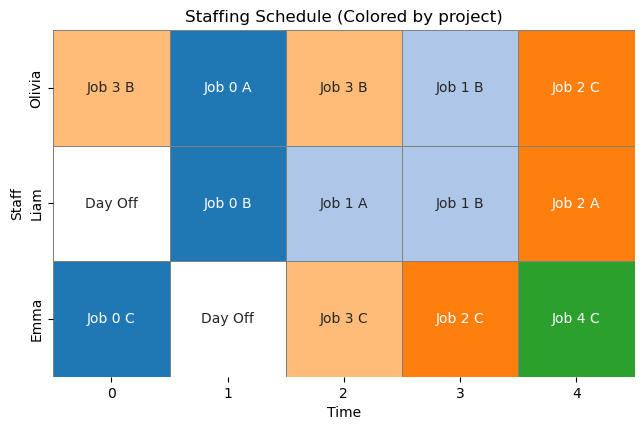

In [172]:
# Extraire uniquement les projets pour le mapping couleur
def extract_project(val):
    if val in ["", "Day Off"]:
        return "Day Off"
    return val.split()[1]  # "Proj X" → "X"

project_table = table_plot.applymap(extract_project)

# Liste des projets uniques (hors "Day Off")
unique_projects = sorted(list(set(v for v in project_table.values.flatten() if v not in ["", "Day Off"])))

# Mapping projet → entier pour heatmap
project_to_int = {"Day Off": 0}
project_to_int.update({v: i+1 for i, v in enumerate(unique_projects)})

int_table = project_table.replace(project_to_int).astype(int)

# Palette : blanc pour "Day Off", puis couleurs pour projets
palette = [(1,1,1)] + sns.color_palette("tab20", len(unique_projects))

# Plot
plt.figure(figsize=(h*1.5, staff_nb*1.5))
ax = sns.heatmap(int_table, annot=table_plot.values, fmt='',
                 cmap=palette,
                 cbar=False,
                 linewidths=0.5, linecolor='gray')

ax.set_xlabel("Time")
ax.set_ylabel("Staff")
ax.set_title("Staffing Schedule (Colored by project)")
plt.show()